# Introduction

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
  * Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.
2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
  * You can download the Bitcoin historical data for free from coindesk.com/price/bitcoin and clicking “Export Data” -> “CSV”.
3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?
  * Setup a series of experiments to find whether or not there’s a better window size.
  * For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.
4. Create a windowed dataset just like the ones we used for model_1 using tf.keras.preprocessing.timeseries_dataset_from_array() and retrain model_1 using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
  * Are there any other features you think you could add?
  * If so, try it out, how do these affect the model?
6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made).
8. Plot the results, how do they look compared to the future predictions where a model wasn’t retrained for every forecast (model_9)?
Throughout this notebook, we’ve only tried algorithms we’ve handcrafted ourselves. But it’s worth seeing how a purpose built forecasting algorithm goes.
  * Try out one of the extra algorithms listed in the modelling experiments part such as:
  * Facebook’s Kats library - there are many models in here, remember the machine learning practioner’s motto: experiment, experiment, experiment.
  * LinkedIn’s Greykite library

# Downloading the data and preprocessing

In [1]:
# Download Bitcoin historical data from GitHub
!wget 'https://raw.githubusercontent.com/DavAll22/Bitcoin_Forecast/main/bitcoin_2013-10-01_2023-06-14.csv'

# Re-formatting to import using datetime:
import pandas as pd
df = pd.read_csv('/content/bitcoin_2013-10-01_2023-06-14.csv',
                 parse_dates=['Date'],
                 index_col=['Date']) # parse the date column (column 1 is a datetime)
df.head()

--2023-06-15 12:34:50--  https://raw.githubusercontent.com/DavAll22/Bitcoin_Forecast/main/bitcoin_2013-10-01_2023-06-14.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 339343 (331K) [text/plain]
Saving to: ‘bitcoin_2013-10-01_2023-06-14.csv’

bitcoin_2013-10-01_ 100%[===================>] 331.39K  --.-KB/s    in 0.004s  

2023-06-15 12:34:50 (86.9 MB/s) - ‘bitcoin_2013-10-01_2023-06-14.csv’ saved [339343/339343]



,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-06-12,25910.04,26300.08,25760.04,25910.03,3.377094e+10,5.042019e+11
2023-06-11,25922.89,26081.61,25662.95,25887.59,3.018877e+10,5.018320e+11
2023-06-10,25820.23,26147.84,25676.59,25920.86,3.299485e+10,5.011299e+11
2023-06-09,26481.47,26500.50,25491.91,25842.84,3.586479e+10,5.009359e+11
2023-06-08,26509.38,26766.28,26325.91,26489.46,2.879870e+10,5.143227e+11


In [2]:
df.sort_values(by='Date', ascending = True, inplace = True)
df[:10], df[-10:]

(              Open    High     Low   Close  Volume    Market Cap
 Date                                                            
 2013-09-30  132.68  134.63  131.55  132.18     0.0  1.567875e+09
 2013-10-01  132.05  133.59  102.25  114.13     0.0  1.501799e+09
 2013-10-02  114.45  123.63  111.82  123.63     0.0  1.412675e+09
 2013-10-03  123.41  130.09  123.41  129.01     0.0  1.500255e+09
 2013-10-04  128.63  130.44  128.03  128.55     0.0  1.522529e+09
 2013-10-05  128.36  129.66  126.15  129.00     0.0  1.511180e+09
 2013-10-06  129.43  130.27  126.36  126.94     0.0  1.518677e+09
 2013-10-07  126.74  127.47  124.71  126.00     0.0  1.487193e+09
 2013-10-08  125.85  131.75  125.58  130.69     0.0  1.524165e+09
 2013-10-09  130.67  131.50  129.26  130.59     0.0  1.542156e+09,
                 Open      High       Low     Close        Volume    Market Cap
 Date                                                                          
 2023-06-03  27063.05  27384.43  26978.50  2710

In [3]:
# Only want the closing price per day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-09-30,132.18
2013-10-01,114.13
2013-10-02,123.63
2013-10-03,129.01
2013-10-04,128.55


In [4]:
# Getting the data in an array
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

# Instantiating sklearn MinMaxScalar
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

In [5]:
# Create function to view NumPy arrays as windows

def get_labelled_windows(x , horizon):
  return x[:, :-horizon] ,x[: , -horizon:]


def make_windows_scaled(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size. Also applies the standard scalar
  """
  scalar.fit(np.expand_dims(x , axis =1))
  scaled_x = scalar.transform(np.expand_dims(x , axis = 1))
  scaled_x = np.squeeze(scaled_x)

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(scaled_x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = scaled_x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


# Make the splits
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels

# 1. Scaling the data for univariate & multivariate data

All values between 0 and 1 - does this effect model training or evaluation?

Univariate = model_1

Multivariate = model_6

## Model_1 univariate

In [6]:
# Model 1 (Horizon = 1 , Window_size = 7)
HORIZON = 1
WINDOW_SIZE = 7


full_windows , full_labels = make_windows_scaled(prices , window_size = WINDOW_SIZE , horizon = HORIZON)
full_windows.shape , full_labels.shape

((3536, 7), (3536, 1))

In [7]:
# Looking at few examples of how price is scaled
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label {full_labels[i]}')

Window: [0.00026786 0.         0.00014098 0.00022082 0.00021399 0.00022067
 0.0001901 ] --> Label [0.00017615]
Window: [0.         0.00014098 0.00022082 0.00021399 0.00022067 0.0001901
 0.00017615] --> Label [0.00024575]
Window: [0.00014098 0.00022082 0.00021399 0.00022067 0.0001901  0.00017615
 0.00024575] --> Label [0.00024426]


In [8]:
# Making train and test splits
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2828, 708, 2828, 708)

In [9]:
# Building the Model 1
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation= 'relu') ,
  layers.Dense(HORIZON , activation = 'linear')
])

# Compiling the model
model_1.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['mae'])

# Fit the model
model_1_history = model_1.fit(x = train_windows ,
                              y = train_labels ,
                              epochs = 100 , batch_size = 128 , verbose = 0 ,
                              validation_data = (test_windows , test_labels))

In [10]:
# Evaluate the model on test data
model_1.evaluate(test_windows , test_labels)

23/23 [==============================] - 0s 2ms/step - loss: 0.0140 - mae: 0.0140


[0.014037152752280235, 0.014037152752280235]

In [11]:
# Making predictions
model_1_preds = tf.squeeze(model_1.predict(test_windows))
model_1_preds[:10]

23/23 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.49792528, 0.49460873, 0.4930452 , 0.4797451 , 0.49008167,
       0.48828346, 0.4976998 , 0.4876391 , 0.47418615, 0.4763597 ],
      dtype=float32)>

## Model_6 multivariate

In [12]:
# Block reward values
block_reward_1 = 50 # 3 January 2009
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()


,Price,block_reward
Date,,
2013-09-30,132.18,25
2013-10-01,114.13,25
2013-10-02,123.63,25
2013-10-03,129.01,25
2013-10-04,128.55,25


In [13]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-09-30,132.18,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-01,114.13,25,132.18,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,123.63,25,114.13,132.18,NaN,NaN,NaN,NaN,NaN
2013-10-03,129.01,25,123.63,114.13,132.18,NaN,NaN,NaN,NaN
2013-10-04,128.55,25,129.01,123.63,114.13,132.18,NaN,NaN,NaN
2013-10-05,129.00,25,128.55,129.01,123.63,114.13,132.18,NaN,NaN
2013-10-06,126.94,25,129.00,128.55,129.01,123.63,114.13,132.18,NaN
2013-10-07,126.00,25,126.94,129.00,128.55,129.01,123.63,114.13,132.18
2013-10-08,130.69,25,126.00,126.94,129.00,128.55,129.01,123.63,114.13


In [14]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head(), y.head()

(            block_reward     Price+1     Price+2     Price+3     Price+4  \
 Date                                                                       
 2013-10-07          25.0  126.940002  129.000000  128.550003  129.009995   
 2013-10-08          25.0  126.000000  126.940002  129.000000  128.550003   
 2013-10-09          25.0  130.690002  126.000000  126.940002  129.000000   
 2013-10-10          25.0  130.589996  130.690002  126.000000  126.940002   
 2013-10-11          25.0  130.899994  130.589996  130.690002  126.000000   
 
                Price+5     Price+6     Price+7  
 Date                                            
 2013-10-07  123.629997  114.129997  132.179993  
 2013-10-08  129.009995  123.629997  114.129997  
 2013-10-09  128.550003  129.009995  123.629997  
 2013-10-10  129.000000  128.550003  129.009995  
 2013-10-11  126.940002  129.000000  128.550003  ,
 Date
 2013-10-07    126.000000
 2013-10-08    130.690002
 2013-10-09    130.589996
 2013-10-10    130.89999

In [15]:
# Scaling the X data
X_scaled = scalar.fit_transform(X)
y_scaled = scalar.fit_transform(np.expand_dims(y , axis = 1))
y_scaled = np.squeeze(y_scaled)

In [16]:
# Make train and test set splits of the scaled data
split_size = int(len(X) * 0.8)
X_train, y_train = X_scaled[:split_size], y_scaled[:split_size]
X_test, y_test = X_scaled[split_size:], y_scaled[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2828, 2828, 708, 708)

In [17]:
# Building a Multivariate time series model and fitting it
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128 , activation= 'relu'),
  layers.Dense(HORIZON)
])

model_6.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam())

model_6_history = model_6.fit(X_train , y_train ,
                              epochs = 100 ,
                              verbose = 0 , batch_size = 128,
                              validation_data = (X_test , y_test))

In [18]:
# Evaluate the model 6
model_6.evaluate(X_test , y_test)

23/23 [==============================] - 0s 3ms/step - loss: 0.0127


0.012700935825705528

In [19]:
# Making predictions
model_1_preds = tf.squeeze(model_1.predict(test_windows))

23/23 [==============================] - 0s 2ms/step


# 3. Window size experimentation

Training 10 diferent models with widnow sizes from 2-13 and 1 horizon.

In [20]:
# Writing a evaluation function based on the preds and targets
def evaluate_preds(y_true , y_pred):

  # Casting the values to float32
  y_true = tf.cast(y_true , tf.float32)
  y_pred = tf.cast(y_pred , tf.float32)


  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true , y_pred)

  # For longer horizons
  if mae.ndim > 0:
    mae = tf.reduce_sum(mae)
    mse = tf.reduce_sum(mse)
    rmse = tf.reduce_sum(rmse)
    mape = tf.reduce_sum(mape)

  return {'mae' : mae.numpy() ,
          'mse': mse.numpy() ,
          'rmse': rmse.numpy() ,
          'mape': mape.numpy() }

In [21]:
# Function to make windows for whole time series data using numpy array indexing
# Same function as before, but without scaling

def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  # 3. Index on target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the lebeleld windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [22]:
# Writing a for loop to iterate over the Window size and build 10 different models

# 10 Different models with window size ranging from (2 - 12) and store the results
model_results_list = []

from tqdm import tqdm # Progress bar updates 1 step when 1 model has been completed with a window size
for size in tqdm(range(2,12)):
  HORIZON = 1
  WINDOW_SIZE = size

  # Making window and labels
  full_windows , full_labels = make_windows(prices, window_size= WINDOW_SIZE , horizon= HORIZON)


  # Splitting the data in train and test
  train_windows ,  test_windows ,train_labels,  test_labels = make_train_test_splits(full_windows , full_labels)


  # Building a simple dense model
  input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer')
  x = layers.Dense(128 , activation= 'relu')(input)
  output = layers.Dense(HORIZON , activation= 'linear')(x)

  # Packing into a model
  model = tf.keras.Model(input , output , name = f'model_windowed_{size}')

  # Compiling and fitting the model
  model.compile(loss = 'mae' , optimizer = 'adam' , metrics = 'mae')

  model.fit(train_windows , train_labels ,
            epochs = 100 , verbose = 0 ,
            batch_size = 128 ,
            validation_data = (test_windows , test_labels))


  # Making predictions
  preds_ = model.predict(test_windows)
  y_preds = tf.squeeze(preds_)

  results = evaluate_preds(tf.squeeze(test_labels) , y_preds)
  model_results_list.append(results)

  0%|          | 0/10 [00:00<?, ?it/s]

23/23 [==============================] - 0s 2ms/step


 10%|█         | 1/10 [00:21<03:11, 21.31s/it]

23/23 [==============================] - 0s 1ms/step


 20%|██        | 2/10 [00:33<02:06, 15.84s/it]

23/23 [==============================] - 0s 1ms/step


 30%|███       | 3/10 [00:46<01:41, 14.46s/it]

23/23 [==============================] - 0s 4ms/step


 40%|████      | 4/10 [01:07<01:43, 17.27s/it]

23/23 [==============================] - 0s 2ms/step


 50%|█████     | 5/10 [01:29<01:34, 18.91s/it]

23/23 [==============================] - 0s 2ms/step


 60%|██████    | 6/10 [01:50<01:18, 19.66s/it]

23/23 [==============================] - 0s 1ms/step


 70%|███████   | 7/10 [02:01<00:50, 16.78s/it]

23/23 [==============================] - 0s 1ms/step


 80%|████████  | 8/10 [02:11<00:29, 14.76s/it]

23/23 [==============================] - 0s 2ms/step


 90%|█████████ | 9/10 [02:33<00:16, 16.78s/it]

23/23 [==============================] - 0s 2ms/step


100%|██████████| 10/10 [02:44<00:00, 16.41s/it]


In [23]:
# Below are the 10 different models result
model_results_list

[{'mae': 778.14935, 'mse': 1398654.5, 'rmse': 1182.6472, 'mape': 2.305723},
 {'mae': 952.8092, 'mse': 1773946.6, 'rmse': 1331.8959, 'mape': 2.8206265},
 {'mae': 907.0029, 'mse': 1700009.2, 'rmse': 1303.844, 'mape': 2.728623},
 {'mae': 817.8255, 'mse': 1488321.9, 'rmse': 1219.9679, 'mape': 2.4252703},
 {'mae': 905.08905, 'mse': 1695910.8, 'rmse': 1302.2714, 'mape': 2.7207751},
 {'mae': 1032.6215, 'mse': 1995873.5, 'rmse': 1412.7539, 'mape': 3.0712655},
 {'mae': 785.4647, 'mse': 1419487.2, 'rmse': 1191.4224, 'mape': 2.3141468},
 {'mae': 800.4836, 'mse': 1461144.2, 'rmse': 1208.778, 'mape': 2.3669927},
 {'mae': 790.07947, 'mse': 1432437.5, 'rmse': 1196.8447, 'mape': 2.3238575},
 {'mae': 1255.436, 'mse': 2702082.2, 'rmse': 1643.8011, 'mape': 3.77065}]

Function does not evaluate using the best results in training epochs (no callback used like in the last workbook) - here is making predictions using the last epoch's results.

Appears a window size of 3 gives the best results regardless

# 4. Making windowed datasets using `tf.keras.preprocessing.timeseries_dataset_from_array()`

Re-making model_1 but using alternative method

In [24]:
WINDOW_SIZE = 7
HORIZON = 1

In [25]:
# Make the splits
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels


In [26]:
ds = tf.keras.utils.timeseries_dataset_from_array(
    data = prices , targets = prices , sequence_length = WINDOW_SIZE , sequence_stride = HORIZON,
    batch_size = 128
)

In [27]:
train_size , test_size = int(0.8 * len(ds)) ,int(0.2 * len(ds))

In [28]:
# Creating dataset splits from the windows
train_ds = ds.take(train_size)
test_ds = ds.skip(train_size).take(test_size)

In [29]:
for x , y in train_ds.take(1):
  print(x[:2] , y[:2])

tf.Tensor(
[[132.18 114.13 123.63 129.01 128.55 129.   126.94]
 [114.13 123.63 129.01 128.55 129.   126.94 126.  ]], shape=(2, 7), dtype=float64) tf.Tensor([132.18 114.13], shape=(2,), dtype=float64)


In [30]:
for x , y in test_ds.take(1):
  print(x[:2] , y[:2])

tf.Tensor(
[[38082.08       35577.47       35635.38       35648.51716347
  31606.39       32366.97       33646.15      ]
 [35577.47       35635.38       35648.51716347 31606.39
  32366.97       33646.15       34580.351177  ]], shape=(2, 7), dtype=float64) tf.Tensor([38082.08 35577.47], shape=(2,), dtype=float64)


In [31]:
# Building the Model 1 with the updated data
tf.random.set_seed(42)

# Building a simple dense model
input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer' , dtype = tf.float32)
x = layers.Dense(128 , activation= 'relu')(input)
output = layers.Dense(HORIZON , activation= 'linear')(x)

# Packing into a model
model = tf.keras.Model(input , output)

# Compiling the model
model.compile(loss = 'mae' ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['mae'])

# Fit the model
model.fit(train_ds ,
          epochs = 100 , verbose = 1 ,
          validation_data = test_ds)

Epoch 1/100
22/22 [==============================] - 2s 38ms/step - loss: 353.3478 - mae: 353.3478 - val_loss: 1162.4128 - val_mae: 1162.4128
Epoch 2/100
22/22 [==============================] - 1s 34ms/step - loss: 403.8473 - mae: 403.8473 - val_loss: 920.4825 - val_mae: 920.4825
Epoch 3/100
22/22 [==============================] - 1s 48ms/step - loss: 612.2552 - mae: 612.2552 - val_loss: 1736.2594 - val_mae: 1736.2594
Epoch 4/100
22/22 [==============================] - 1s 35ms/step - loss: 338.1854 - mae: 338.1854 - val_loss: 870.6381 - val_mae: 870.6381
Epoch 5/100
22/22 [==============================] - 1s 35ms/step - loss: 522.4657 - mae: 522.4657 - val_loss: 1205.4996 - val_mae: 1205.4996
Epoch 6/100
22/22 [==============================] - 1s 36ms/step - loss: 225.8116 - mae: 225.8116 - val_loss: 835.3959 - val_mae: 835.3959
Epoch 7/100
22/22 [==============================] - 1s 35ms/step - loss: 221.2591 - mae: 221.2591 - val_loss: 918.6849 - val_mae: 918.6849
Epoch 8/100
22

In [32]:
# Evaluating the model on the test set
model.evaluate(test_ds)

5/5 [==============================] - 0s 17ms/step - loss: 1015.9725 - mae: 1015.9725


[1015.9724731445312, 1015.9724731445312]

# 5. Multivariate modelling with 3 features

Combining the prices, block reward size and days of the week

In [33]:
df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-09-30,132.68,134.63,131.55,132.18,0.000000e+00,1.567875e+09
2013-10-01,132.05,133.59,102.25,114.13,0.000000e+00,1.501799e+09
2013-10-02,114.45,123.63,111.82,123.63,0.000000e+00,1.412675e+09
2013-10-03,123.41,130.09,123.41,129.01,0.000000e+00,1.500255e+09
2013-10-04,128.63,130.44,128.03,128.55,0.000000e+00,1.522529e+09
...,...,...,...,...,...,...
2023-06-08,26509.38,26766.28,26325.91,26489.46,2.879870e+10,5.143227e+11
2023-06-09,26481.47,26500.50,25491.91,25842.84,3.586479e+10,5.009359e+11
2023-06-10,25820.23,26147.84,25676.59,25920.86,3.299485e+10,5.011299e+11


In [34]:
# Adding the day of the week to the dataframe (could influence price)
# e.g. monday = 0, tuesday = 1 etc.
import datetime
# Creating a day of week feature
df['day_of_week'] = df.index.dayofweek
df.head(10)

,Open,High,Low,Close,Volume,Market Cap,day_of_week
Date,,,,,,,
2013-09-30,132.68,134.63,131.55,132.18,0.0,1.567875e+09,0
2013-10-01,132.05,133.59,102.25,114.13,0.0,1.501799e+09,1
2013-10-02,114.45,123.63,111.82,123.63,0.0,1.412675e+09,2
2013-10-03,123.41,130.09,123.41,129.01,0.0,1.500255e+09,3
2013-10-04,128.63,130.44,128.03,128.55,0.0,1.522529e+09,4
2013-10-05,128.36,129.66,126.15,129.00,0.0,1.511180e+09,5
2013-10-06,129.43,130.27,126.36,126.94,0.0,1.518677e+09,6
2013-10-07,126.74,127.47,124.71,126.00,0.0,1.487193e+09,0
2013-10-08,125.85,131.75,125.58,130.69,0.0,1.524165e+09,1


In [35]:
# Defining the hyper parameters
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed['day_of_week'] = bitcoin_prices_windowed.index.dayofweek

In [36]:
# Getting three kinds of data (univariate , multivariate and the day of week)

# Univariate data
full_windows , full_labels = make_windows_scaled(prices)
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)

# Multivaritate dat
X = bitcoin_prices_windowed.dropna().drop('Price' , axis = 1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

# Day of week
day_of_week = bitcoin_prices_windowed.dropna()['day_of_week'].to_list()

In [37]:
# Checking the shapes
print(full_windows.shape , full_labels.shape)
print(X.shape , y.shape)
print(len(day_of_week))

(3536, 7) (3536, 1)
(3536, 9) (3536,)
3536


Building the datasets

In [38]:
# Splitting the multivariate and the day_of_week to train and test splits
split_size = int(len(X) * 0.8)
train_block_rewards , test_block_rewards = X[:split_size] , X[split_size:]
train_days , test_days = day_of_week[:split_size] , day_of_week[split_size:]

len(train_block_rewards), len(train_days) , len(test_block_rewards) , len(test_days)

(2828, 2828, 708, 708)

In [39]:
# Building a performant dataset for train and test

train_data_tribid = tf.data.Dataset.from_tensor_slices((train_windows ,
                                                        train_block_rewards ,
                                                        train_days))

train_labels_tribid = tf.data.Dataset.from_tensor_slices(train_labels)

# The test/val split
test_data_tribid = tf.data.Dataset.from_tensor_slices((test_windows ,
                                                       test_block_rewards ,
                                                       test_days))

test_labels_tribid = tf.data.Dataset.from_tensor_slices(test_labels)

# Zipping the data and labels into one complete dataset
tribid_train_ds = tf.data.Dataset.zip((train_data_tribid , train_labels_tribid))
tribid_test_ds = tf.data.Dataset.zip((test_data_tribid , test_labels_tribid))

# Applying prefetch and batching the dataset
tribid_train_ds = tribid_train_ds.batch(128).prefetch(tf.data.AUTOTUNE)
tribid_test_ds = tribid_test_ds.batch(128).prefetch(tf.data.AUTOTUNE)

tribid_train_ds ,tribid_test_ds

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

Building the model

In [40]:
# Building a tribid model

input_windows = layers.Input(shape = (7,) , dtype=tf.float64 , name='Window Inputs')
expand_layer_1 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_windows) # resizing
conv1 = layers.Conv1D(filters= 32 , kernel_size=5 , padding='causal' , activation= 'relu')(expand_layer_1)
window_model = tf.keras.Model(input_windows , conv1 , name = 'Windowed model')

input_blocks = layers.Input(shape = (9,) , dtype= tf.float32 , name ='Block rewards input')
expand_layer_2 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_blocks) # resizing
conv2 = layers.Conv1D(filters = 32 , kernel_size= 5 , activation= 'relu' , padding = 'causal')(expand_layer_2)
block_model = tf.keras.Model(input_blocks , conv2 , name = 'Block rewards model')


# Use expand dims to match the same shape output (None , 1 , 128)
# whereas without expand dims it would be (None , 128)
input_days = layers.Input(shape= (1,) , dtype = tf.int32 , name ='Days of week Input')
expand_layer_3 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_days)
dense = layers.Dense(128 , activation= 'relu')(expand_layer_3)
days_model = tf.keras.Model(input_days , dense , name = 'Days Model')

# Concatenating the inputs
concat = layers.Concatenate(name = 'combined_outputs' )([window_model.output ,
                                                           block_model.output ,
                                                           days_model.output])

# Creating the output layer
dropout = layers.Dropout(0.5)(concat)
output_layer = layers.Dense(1 , activation = 'linear')(dropout)

# Putting everything into a model
tribrid_model = tf.keras.Model(inputs = [window_model.input ,
                                        block_model.input ,
                                        days_model.input] ,
                              outputs = output_layer)
tribrid_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Window Inputs (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 Block rewards input (InputLaye  [(None, 9)]         0           []                               
 r)                                                                                               
                                                                                                  
 Days of week Input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                            

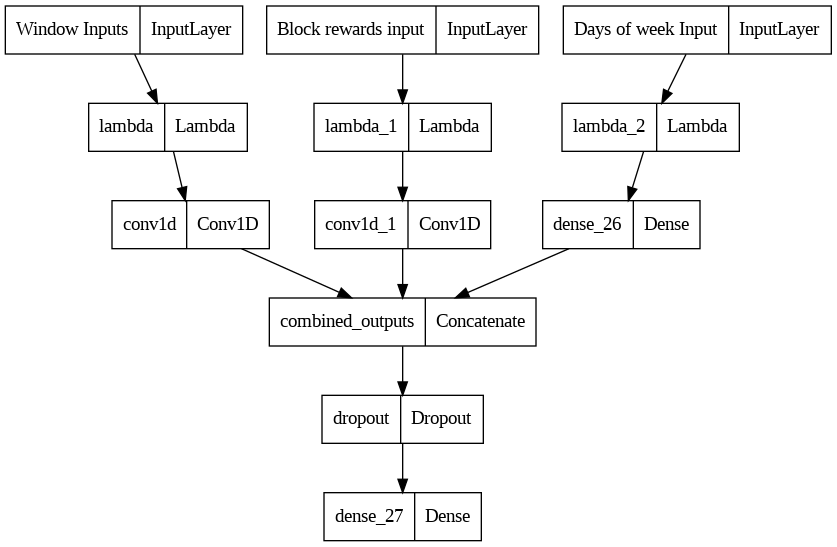

In [41]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(tribrid_model)

In [42]:
# Compiling and fitting the model
tribrid_model.compile(loss='mae',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['mae'])

# Fitting the model
tribrid_model.fit(tribid_train_ds,
                 epochs = 20,
                 validation_data = tribid_test_ds , verbose = 2)

Epoch 1/20
23/23 - 8s - loss: 790.6692 - mae: 790.6692 - val_loss: 626.2709 - val_mae: 626.2709 - 8s/epoch - 356ms/step
Epoch 2/20
23/23 - 0s - loss: 624.4527 - mae: 624.4527 - val_loss: 49.6318 - val_mae: 49.6318 - 116ms/epoch - 5ms/step
Epoch 3/20
23/23 - 0s - loss: 507.0270 - mae: 507.0270 - val_loss: 153.2520 - val_mae: 153.2520 - 129ms/epoch - 6ms/step
Epoch 4/20
23/23 - 0s - loss: 352.7021 - mae: 352.7021 - val_loss: 38.3141 - val_mae: 38.3141 - 114ms/epoch - 5ms/step
Epoch 5/20
23/23 - 0s - loss: 286.1974 - mae: 286.1974 - val_loss: 88.1203 - val_mae: 88.1203 - 124ms/epoch - 5ms/step
Epoch 6/20
23/23 - 0s - loss: 231.0936 - mae: 231.0936 - val_loss: 43.9808 - val_mae: 43.9808 - 117ms/epoch - 5ms/step
Epoch 7/20
23/23 - 0s - loss: 188.1852 - mae: 188.1852 - val_loss: 183.2830 - val_mae: 183.2830 - 118ms/epoch - 5ms/step
Epoch 8/20
23/23 - 0s - loss: 133.1009 - mae: 133.1009 - val_loss: 317.3421 - val_mae: 317.3421 - 130ms/epoch - 6ms/step
Epoch 9/20
23/23 - 0s - loss: 75.3673 - m

In [43]:
# Evaluating the model
tribrid_model.evaluate(tribid_test_ds)

6/6 [==============================] - 0s 4ms/step - loss: 0.1449 - mae: 0.1449


[0.14486482739448547, 0.14486482739448547]

# 6. Make prediction intervals for future forecasts

* Train ensemble model on whole data
* Make one dataset (no train/test)
* Make a function to take number of iteration and different loss functions to train the model with

In [44]:
# Make one whole dataset (with the updated bitcoin prices 2014 - 2021)

X_all = bitcoin_prices_windowed.drop(['Price' , 'block_reward' , 'day_of_week'] , axis = 1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

whole_ds = tf.data.Dataset.from_tensor_slices((X_all , y_all))
whole_ds = whole_ds.batch(128).prefetch(tf.data.AUTOTUNE)
whole_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [45]:
# Creating the function (same as in other workbook)

def get_ensemble_models(horizon = HORIZON ,
                        dataset = whole_ds ,
                        num_iter = 10 ,
                        num_epochs = 100 ,
                        loss_fns = ['mae' , 'mse' , 'mape']):


  # Make a empty list of the ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss functions
  for i in range(num_iter):
    for loss_functions in loss_fns:
      print(f'Optimizing model by reducing: {loss_functions} for {num_epochs} epochs, model number: {i}')

      model = tf.keras.Sequential([
          layers.Dense(128 , kernel_initializer='he_normal' , activation= 'relu'),
          layers.Dense(128 , kernel_initializer= 'he_normal', activation= 'relu'),
          layers.Dense(HORIZON)
      ])

      # Compiling the model
      model.compile(loss = loss_functions ,
                    optimizer = 'adam' , metrics = ['mae' , 'mse'])

      # Fit the model
      model.fit(dataset ,
                epochs = num_epochs ,
                verbose = 0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                                                patience=100,
                                                                verbose=1)])

      ensemble_models.append(model)

  return ensemble_models

In [46]:
# Running the above function
ensemble_models = get_ensemble_models(num_iter=5 , num_epochs= 1000 , horizon = 1)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 530: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 426: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 581: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 307: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 407: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 420: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 674: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 393: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 494: ReduceLROnPl

In [47]:
# Making future forecastts of Bitcoins (using the whole data) (same function as in other workbook)
def make_future_forecast(values , model_list , into_future , window_size):

  future_forecast = []
  last_window = values[-window_size:]

  for _ in range(into_future):
    for model in model_list:

      future_pred = model.predict(tf.expand_dims(last_window, axis= 0))
      #future_pred = model.predict(last_window)
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

      future_forecast.append(tf.squeeze(future_pred).numpy())

      # Update the last window
      last_window = np.append(last_window , future_pred)[-window_size:]
  return future_forecast

In [48]:
# Getting the future forecast
future_forecast = make_future_forecast(y_all , ensemble_models , into_future= 14 , window_size = 7 )

1/1 [==============================] - 0s 69ms/step
Predicing on: 
 [26359.59 26493.46 26489.46 25842.84 25920.86 25887.59 25910.03] --> Prediction: 26172.103515625

1/1 [==============================] - 0s 86ms/step
Predicing on: 
 [26493.46       26489.46       25842.84       25920.86
 25887.59       25910.03       26172.10351562] --> Prediction: 26538.130859375

1/1 [==============================] - 0s 78ms/step
Predicing on: 
 [26489.46       25842.84       25920.86       25887.59
 25910.03       26172.10351562 26538.13085938] --> Prediction: 26512.921875



1/1 [==============================] - 0s 79ms/step
Predicing on: 
 [25842.84       25920.86       25887.59       25910.03
 26172.10351562 26538.13085938 26512.921875  ] --> Prediction: 25917.232421875



1/1 [==============================] - 0s 72ms/step
Predicing on: 
 [25920.86       25887.59       25910.03       26172.10351562
 26538.13085938 26512.921875   25917.23242188] --> Prediction: 25914.103515625

1/1 [==============================] - 0s 79ms/step
Predicing on: 
 [25887.59       25910.03       26172.10351562 26538.13085938
 26512.921875   25917.23242188 25914.10351562] --> Prediction: 25546.994140625

1/1 [==============================] - 0s 73ms/step
Predicing on: 
 [25910.03       26172.10351562 26538.13085938 26512.921875
 25917.23242188 25914.10351562 25546.99414062] --> Prediction: 25738.900390625

1/1 [==============================] - 0s 90ms/step
Predicing on: 
 [26172.10351562 26538.13085938 26512.921875   25917.23242188
 25914.10351562 25546.99414062 25738.90039062] --> Prediction: 26182.140625

1/1 [==============================] - 0s 73ms/step
Predicing on: 
 [26538.13085938 26512.921875   25917.23242188 25914.10351562
 25546.99414062 25738.90039062 26182.140

# 7. For future predictions, re-train the model each time a new prediction is made

- append pred to list -> train new model
- make a pred on new list (with new model)
- append new pred to list -> train new model
- make a pred on new list (with new model)
- append new pred to list -> train new model
- make a pred on new list (with new model)
- #7 is train a new model every single time a pred is made

In [49]:
# Lets code things at first without a loop and see how it foes
HORIZON = 1
WINDOW_SIZE = 7

# Building a model (You can replace it with any model)
def get_model(horizon = HORIZON):
    model = tf.keras.Sequential([
            layers.Dense(128 , activation = 'relu'),
            layers.Dense(128 , activation = 'relu'),
            layers.Dense(horizon)
        ])

    model.compile(loss = tf.keras.losses.mae ,
                  optimizer = tf.keras.optimizers.Adam())


    return model

In [50]:
#. Making the data and labels for window size of 7 and horizon of 1
full_windows , full_labels = make_windows(prices , window_size= WINDOW_SIZE , horizon= HORIZON)

In [51]:
# Making future forecasts of Bitcoin (using the whole data)
def pred_model_run(values , X, model , into_future , window_size  , horizon, epochs ):

  '''
  This function train a model for every updated predictions.

  Arguments:
  ----------
      - values --> labels / truth values. Bitcoin prices
      - X --> Windowed data of the bitcoin prices (default window size is 7)
      - model --> compiled model with default horizon 1
      - into_future -->  how many time steps to predict in the future?
      - window_size --> default is 7 (using the 7 days prices of bitcoin)
      - horizon --> default is 1 (predicting the price of next day)

  Returns:
  --------
      - model --> a model that has been trained on all the previous predictions + the data
  '''

  last_window = values[-window_size:]
  X_all = X
  y_all = values
  for _ in range(into_future):

      # Each time the model is trained for 5 epochs with the updated data
      model.fit(x = X_all , y = y_all , epochs = epochs , verbose = 0)

      future_pred = model.predict(tf.expand_dims(last_window, axis= 0))
      #future_pred = model.predict(last_window)
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

      future_forecast.append(tf.squeeze(future_pred).numpy())
      #values = np.append(values , tf.squeeze(future_pred).numpy())
      for i in range(0 , len(X_all)):
        x = X_all[i][1:]  # removing the 0th index of the X window ()
        y = y_all[1:] # removing the 0th index  of y
        X = np.append(x , future_pred) # append the future pred at last to X window
        values = np.append(y , future_pred) # appending the future pred to y

      # Update the last window
      last_window = np.append(last_window , future_pred)[-window_size:]


  return model

In [52]:
full_windows.shape , X_all.shape , full_labels.shape , y_all.shape

((3536, 7), (3536, 7), (3536, 1), (3536,))

In [53]:
# Using the above function
trained_model = pred_model_run(values = tf.squeeze(full_labels) ,
                               X = full_windows ,
                               model = get_model(horizon = 1) ,
                               window_size = WINDOW_SIZE ,
                               horizon = HORIZON ,
                               epochs = 10 ,
                               into_future  =14 )

1/1 [==============================] - 0s 46ms/step
Predicing on: 
 [26359.59 26493.46 26489.46 25842.84 25920.86 25887.59 25910.03] --> Prediction: 26244.83984375

1/1 [==============================] - 0s 21ms/step
Predicing on: 
 [26493.46       26489.46       25842.84       25920.86
 25887.59       25910.03       26244.83984375] --> Prediction: 26202.529296875

1/1 [==============================] - 0s 18ms/step
Predicing on: 
 [26489.46       25842.84       25920.86       25887.59
 25910.03       26244.83984375 26202.52929688] --> Prediction: 26946.435546875

1/1 [==============================] - 0s 17ms/step
Predicing on: 
 [25842.84       25920.86       25887.59       25910.03
 26244.83984375 26202.52929688 26946.43554688] --> Prediction: 27313.15234375

1/1 [==============================] - 0s 17ms/step
Predicing on: 
 [25920.86       25887.59       25910.03       26244.83984375
 26202.52929688 26946.43554688 27313.15234375] --> Prediction: 27862.380859375

1/1 [=============

# 8. Using a purpose-build forecasting algorithm (Facebook Kat's Library)

Try out one of the extra algorithms listed in the modelling experiments part such as:

[Facebook’s Kats library](https://github.com/facebookresearch/Kats) - there are many models in here

[LinkedIn’s Greykite library](https://github.com/linkedin/greykite)

In [56]:
# Installing facebooks kats lib
!pip install kats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kats-0.2.0-py3-none-any.whl (612 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
  Using cached numpy-1.21.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
  Using cached pandas-1.3.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.9 MB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached statsmodels-0.12.2.tar.gz (17.5 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subpr

In [55]:
# Importing the TimeSerisData class from Kats
from kats.consts import TimeSeriesData

ModuleNotFoundError: ignored

In [ ]:
# Utils to work with Kats
from dateutil import parser
from datetime import datetime

In [ ]:
# Creating a Dataset object with Kats
ts_data = TimeSeriesData(time = bitcoin_prices.index ,
               value = bitcoin_prices.Price)

type(ts_data)

In [ ]:
# Plotting the timeseries data
import matplotlib.pyplot as plt

ts_data.plot(cols=['Price'])
plt.show()

Forecasting with the Prophet model

In [ ]:
# Importing the prophet
from kats.models.prophet import ProphetModel , ProphetParams

# Creating a model param instance
params = ProphetParams(seasonality_mode= 'multiplicative')

# Create a prophet model instance (just like how we create an instance in sklearn)
model = ProphetModel(ts_data , params)

# Fitting the model
model.fit()

# Making predictions
forecast = model.predict(steps= 1 , include_history= True , freq = '1W')

In [ ]:
# Predicting the bitcoin price for a day (Horizon = 1 )
forecast.head(10)

Ensemble of models using Kat's library using `KatEnsemble`

In [ ]:

# Importing the things we need
from kats.models.ensemble.ensemble import EnsembleParams , BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    holtwinters ,
    linear_model ,
    prophet ,
    quadratic_model ,
    sarima ,
    theta
)

In [ ]:

# Defining the parameters of different models
model_params = EnsembleParams(
    [
     BaseModelParams('arima' , arima.ARIMAParams(p = 1 , d=1 , q=1)) ,
     BaseModelParams('sarima' ,
                     sarima.SARIMAParams(
                         p = 2 , d= 2 , q =1 , trend = 'ct' ,
                     seasonal_order = (1, 0 ,1 ,12) , enforce_invertibility = False ,
                     enforce_stationarity = False),
     ),
     BaseModelParams('prophet' , prophet.ProphetParams()) ,
     BaseModelParams('linear' , linear_model.LinearModelParams()) ,
     BaseModelParams('quadratic' , quadratic_model.QuadraticModelParams()),
     BaseModelParams('theta' , theta.ThetaParams()),
    ]
)

In [ ]:

# Creating KatEnsembleParam with detailed configuration
KatEnsembleParams = {
    'models': model_params ,
    'aggregation': 'median' ,
    'seasonality_length': 7 ,
    'decomposition_method': 'multiplicative'
}

In [ ]:
# Creating a Time Series dataset
bitcoin_ts = TimeSeriesData(value = bitcoin_prices.Price,
                            time = bitcoin_prices.index ,
                            sort_by_time= True)

In [ ]:
# Creating a KatEnsemble model (or) instantiating it
ensemble_model = KatsEnsemble(
    data = bitcoin_ts ,
    params = KatEnsembleParams
)

# Fitting the model
ensemble_model.fit()

In [ ]:
# Making prediction for the next 30 days
forecast = ensemble_model.predict(steps = 30)

In [ ]:
# Aggregate individual model results (we will get the predictions for 30 Days)
ensemble_model.aggregate()

In [ ]:
# Plotting the model
ensemble_model.plot()